In [1]:
import re
import xapian
import pandas as pd
import numpy as np
import csv

In [2]:
import json

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200
pd.options.display.precision = 2

In [5]:
#SOURCES = ['dev', 'train', 'test']
SOURCES = ['dev']
#SOURCES = ['test']
SOURCES = ['train']
SEARCH_RESULT_PATH = "data/search_results_v4_{}.csv".format(SOURCES[0])

# Analyse Found Sentences

## Read Claims

In [6]:
claims_df = pd.read_csv('data/claims.csv', index_col='claim_id')
claims_df = claims_df[claims_df.source.isin(SOURCES)]

In [7]:
labelled_claims_df = pd.read_json('data/l_claims.json')
labelled_claims_df.index.name = 'claim_id'
labelled_claims_df = labelled_claims_df[labelled_claims_df.source.isin(SOURCES)]

In [8]:
gld_ev_sent_count = labelled_claims_df.evidence_sentence_count.sum()
('Total Supporting Sentences', gld_ev_sent_count)

('Total Supporting Sentences', 204041)

In [9]:
gld_ev_doc_count = labelled_claims_df.evidence_doc_count.sum()
('Total Supporting Documents', gld_ev_doc_count)

('Total Supporting Documents', 140085)

## Read search results

In [10]:
import unicodedata

In [11]:
results_df = pd.read_csv(SEARCH_RESULT_PATH)
normalise = lambda item: unicodedata.normalize('NFD', item) if isinstance(item, str) else item
results_df['found_doc'] = results_df['found_doc'].apply(normalise)
#results_df.set_index('claim_id', inplace=True)

In [12]:
#results_df = results_df.sample(int(1e6))

In [13]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13715398 entries, 0 to 13715397
Data columns (total 7 columns):
claim_id      int64
found_doc     object
sent_id       int64
rank          int64
percentage    int64
weight        float64
text          object
dtypes: float64(1), int64(4), object(2)
memory usage: 732.5+ MB


In [14]:
results_df = results_df.join(claims_df.claim, on='claim_id')

In [15]:
golden_evidence = {(claim_id, evidence[0], evidence[1]) 
                        for claim_id, item in labelled_claims_df.evidence.items() \
                        for evidence in item
                  }

In [16]:
cols = ['claim_id', 'found_doc', 'sent_id']

In [17]:
func = lambda v: (v['claim_id'], v['found_doc'], v['sent_id']) in golden_evidence
results_df['label'] = results_df[cols].apply(func, axis=1)

In [18]:
results_df.label.sum()

111644

In [20]:
results_df.label = results_df.label.astype(int)

In [21]:
mask = results_df['label'] == 1
N = int(1.1e5)
train_df = pd.concat([results_df[mask].sample(N), results_df[~mask].sample(N)])

In [22]:
train_df[['claim', 'text', 'label']].to_csv('data/sentence_selection_training_set_220k.csv', index=False)

## Read claims

In [24]:
sources = SOURCES
if 'test' in sources:
    sources.remove('test')
    
labelled_claims_df = pd.read_json('data/l_claims.json').sort_index()
labelled_claims_df.index.name = 'claim_id'
mask = labelled_claims_df.source.isin(sources)
labelled_claims_df = labelled_claims_df[mask]

## Estimate index-search performance

In [25]:
def calculate_recall(mask):
    func = lambda x: set(x)
    found_docs_df = results_df[mask].pivot_table(index='claim_id', values='found_doc', aggfunc=func)

    recall_df = labelled_claims_df[['evidence_docs', 'source', 'claim']].join(found_docs_df)

    def func(x):
        if isinstance(x['found_doc'], set):
            return set(x['evidence_docs']).difference(x['found_doc'])
        return set(x['evidence_docs'])

    recall_df['missed_docs'] = recall_df.apply(func, axis=1)
    recall_df['missed_count'] = recall_df['missed_docs'].apply(len)

    recall_df = recall_df.pivot_table(index='missed_count', columns='source',# margins=True,
                                                    values='claim', aggfunc='count', fill_value=0)
    return recall_df

In [26]:
results_df = labelled_claims_df[['claim']].join(results_df).reset_index()

In [27]:
results_df['row_number'] = results_df.sort_values(['claim_id', 'weight'], ascending=[True, False]) \
                                      .groupby('claim_id') \
                                      .cumcount() + 1

In [28]:
df = results_df[(results_df.row_number <= 5)].copy()

In [29]:
def get_pair(v):
    return list((v['found_doc'], v['sent_id']))
df['evidence'] = df.apply(get_pair, axis=1)

In [30]:
df = df.groupby(['claim_id', 'claim'])[['evidence']].agg(lambda x: list(x)).reset_index()
df['label'] = 'SUPPORTS'
df.set_index('claim_id', inplace=True)

In [31]:
df.to_json('test_set_results.json', orient='index')

In [32]:
!python score.py dev_results.json devset.json

Error processing line 2 of /anaconda/lib/python3.6/site-packages/gapic_google_cloud_datastore_v1-0.15.3-py3.6-nspkg.pth:

  Traceback (most recent call last):
    File "/anaconda/lib/python3.6/site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  KeyError: 'google'

Remainder of file ignored
Label Accuracy 		33.33%
Sentence Precision 	42.33%
Sentence Recall 	6.71%
Sentence F1 		11.59%
Document Precision 	53.90%
Document Recall 	8.74%
Document F1 		15.05%


In [33]:
%%time

results = []
for top in range(5, 101, 5):
    #print(top)
    mask = results_df['rank'] <= top
    
    recall_df = calculate_recall(mask)
    
    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['top'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 1min 33s, sys: 3.28 s, total: 1min 36s
Wall time: 1min 36s


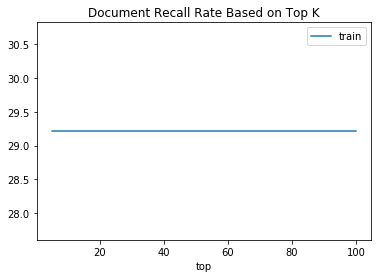

,train
top,
5.0,29.21
10.0,29.21
15.0,29.21
20.0,29.21
25.0,29.21
30.0,29.21
35.0,29.21
40.0,29.21
45.0,29.21


In [34]:
df = pd.DataFrame.from_records(results).set_index('top')
df.plot.line(title='Document Recall Rate Based on Top K')
plt.show()
df#.T

In [35]:
results_df.head()

,claim_id,claim,found_doc,sent_id,rank,percentage,weight,text,row_number
0,3,Chris Hemsworth appeared in A Perfect Getaway.,Chris_Hemsworth,2.0,1.0,87.0,25.15,"Hemsworth has also appeared in the science fiction action film Star Trek (2009), the thriller adventure A Perfect Getaway (2009), the horror comedy The Cabin in the Woods (2012), the dark-fantasy ...",1
1,3,Chris Hemsworth appeared in A Perfect Getaway.,Chris_Hemsworth,0.0,2.0,66.0,19.25,Chris Hemsworth (born 11 August 1983) is an Australian actor .,3
2,3,Chris Hemsworth appeared in A Perfect Getaway.,Chris_Hemsworth,6.0,3.0,49.0,14.23,"The following year, Hemsworth had a supporting role in Sony's reboot of Ghostbusters .",21
3,3,Chris Hemsworth appeared in A Perfect Getaway.,Chris_Hemsworth,7.0,4.0,43.0,12.39,Hemsworth will reprise his role as George Kirk in the upcoming Star Trek sequel .,34
4,3,Chris Hemsworth appeared in A Perfect Getaway.,Chris_Hemsworth,5.0,5.0,10.0,3.05,"In 2015, he starred in the action thriller film Blackhat, had a comedic role in the fifth installment of National Lampoon's Vacation series, Vacation, and headlined the biographical thriller film ...",63


In [36]:
%%time

results = []
for top in range(5, 101, 5):
    #print(top)
    mask = results_df['percentage'] >= top
    
    recall_df = calculate_recall(mask)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['percentage'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 1min 27s, sys: 1.61 s, total: 1min 28s
Wall time: 1min 28s


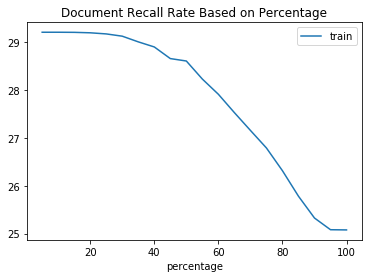

,train
percentage,
5.0,29.21
10.0,29.21
15.0,29.21
20.0,29.20
25.0,29.18
30.0,29.13
35.0,29.01
40.0,28.91
45.0,28.66


In [37]:
df = pd.DataFrame.from_records(results).set_index('percentage')
df.plot.line(title='Document Recall Rate Based on Percentage')
plt.show()
df#.T

In [38]:
results_df.shape[0], results_df[results_df.weight > 14].shape

(1227473, (343031, 9))

In [39]:
%%time

results = []
for top in range(10, 25, 1):
    #print(top)
    mask = results_df['weight'] >= top
    
    recall_df = calculate_recall(mask)

    recall_df = (recall_df / recall_df.sum() * 100).head(1)
    recall_df['weight'] = top
    results += recall_df.to_dict(orient="records")

CPU times: user 1min 5s, sys: 1.08 s, total: 1min 6s
Wall time: 1min 7s


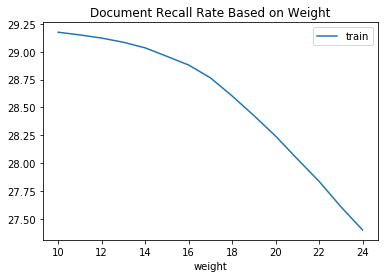

,train
weight,
10.0,29.18
11.0,29.15
12.0,29.12
13.0,29.09
14.0,29.04
15.0,28.96
16.0,28.88
17.0,28.77
18.0,28.60


In [40]:
df = pd.DataFrame.from_records(results).set_index('weight')
df.plot.line(title='Document Recall Rate Based on Weight')
plt.show()
df#.T

## Search performance with filters applied

In [41]:
mask = (results_df['rank'] <= 10) #& (results_df.weight > 10) #& (results_df.percentage > 25)
recall_df = calculate_recall(mask)
recall_df = (recall_df / recall_df.sum() * 100)#.head(1)
recall_df.head(1)

source,train
missed_count,
0,29.21


In [42]:
results_df.found_doc.unique().shape[0], results_df[mask].found_doc.unique().shape[0] 

(123288, 123287)

In [43]:
mask = (results_df['rank'] <= 25)
processed_docs = results_df[mask].found_doc.unique()
len(processed_docs)

123287

In [44]:
mask = (results_df['rank'] <= 50)
docs = results_df[mask].found_doc.unique()
len(docs)

123287

In [45]:
docs = list(set(docs).difference(set(processed_docs)))
len(docs)

0

In [46]:
with open('data/top_26-50_docs.json', 'w') as fp:
    json.dump(list(docs), fp)

## Prepare submission

In [47]:
mask = (results_df['rank'] <= 10) & (results_df.percentage > 25) & (results_df.weight > 15)
submission_df = results_df[mask].set_index('claim_id')[['found_doc']].join(claim_df.claim)
submission_df.head()

,found_doc,claim
3,Chris_Hemsworth,Chris Hemsworth appeared in A Perfect Getaway.
3,Chris_Hemsworth,Chris Hemsworth appeared in A Perfect Getaway.
3,Hemsworth_-LRB-surname-RRB-,Chris Hemsworth appeared in A Perfect Getaway.
3,Hemsworth_-LRB-surname-RRB-,Chris Hemsworth appeared in A Perfect Getaway.
3,Hemsworth_-LRB-surname-RRB-,Chris Hemsworth appeared in A Perfect Getaway.


In [48]:
results_df.shape, submission_df.shape,

((1227473, 9), (300013, 2))

In [49]:
results_df.head()

,claim_id,claim,found_doc,sent_id,rank,percentage,weight,text,row_number
0,3,Chris Hemsworth appeared in A Perfect Getaway.,Chris_Hemsworth,2.0,1.0,87.0,25.15,"Hemsworth has also appeared in the science fiction action film Star Trek (2009), the thriller adventure A Perfect Getaway (2009), the horror comedy The Cabin in the Woods (2012), the dark-fantasy ...",1
1,3,Chris Hemsworth appeared in A Perfect Getaway.,Chris_Hemsworth,0.0,2.0,66.0,19.25,Chris Hemsworth (born 11 August 1983) is an Australian actor .,3
2,3,Chris Hemsworth appeared in A Perfect Getaway.,Chris_Hemsworth,6.0,3.0,49.0,14.23,"The following year, Hemsworth had a supporting role in Sony's reboot of Ghostbusters .",21
3,3,Chris Hemsworth appeared in A Perfect Getaway.,Chris_Hemsworth,7.0,4.0,43.0,12.39,Hemsworth will reprise his role as George Kirk in the upcoming Star Trek sequel .,34
4,3,Chris Hemsworth appeared in A Perfect Getaway.,Chris_Hemsworth,5.0,5.0,10.0,3.05,"In 2015, he starred in the action thriller film Blackhat, had a comedic role in the fifth installment of National Lampoon's Vacation series, Vacation, and headlined the biographical thriller film ...",63


In [50]:
results_df.found_doc.unique().shape, submission_df.found_doc.unique().shape

((123288,), (68202,))

In [51]:
submission_df['label'] = "SUPPORTS"
submission_df['evidence'] = submission_df.found_doc.apply(lambda x: [[x, 0]])

In [52]:
del submission_df['found_doc']

In [53]:
#submission_df.to_json('testoutput.json', orient='index')

In [54]:
submission_df.shape

(300013, 3)

## Evidence found

In [55]:
found_docs_df = results_df.pivot_table(index='claim_id', values='found_doc', aggfunc=list)
recall_df = labelled_claims_df[['evidence_docs', 'source', 'claim']].join(found_docs_df)

def func(x):
    if isinstance(x['found_doc'], list):
        return set(x['evidence_docs']).difference(set(x['found_doc']))
    return set(x['evidence_docs'])

recall_df['missed_docs'] = recall_df.apply(func, axis=1)
recall_df['missed_count'] = recall_df['missed_docs'].apply(len)

In [56]:
recall_df[recall_df.missed_count > 0]

,evidence_docs,source,claim,found_doc,missed_docs,missed_count
claim_id,,,,,,
7,[Roald_Dahl],train,Roald Dahl is a writer.,"[Roald_Dahl_Museum_and_Story_Centre, Roald_Dahl_Museum_and_Story_Centre, The_Collected_Short_Stories_of_Roald_Dahl, The_Collected_Short_Stories_of_Roald_Dahl, Roald_Dahl_Children's_Gallery, Roald_...",{Roald_Dahl},1
8,[Roald_Dahl],train,Roald Dahl is a governor.,"[The_Collected_Short_Stories_of_Roald_Dahl, The_Collected_Short_Stories_of_Roald_Dahl, Roald_Dahl_Children's_Gallery, Roald_Dahl_Children's_Gallery, Roald_Dahl_Children's_Gallery, Roald_Dahl_Child...",{Roald_Dahl},1
19,[H._H._Holmes],train,H. H. Holmes owned a building west of Chicago.,"[Henry_Holmes, Henry_Holmes, Henry_Holmes, Henry_Holmes, Henry_Holmes, Jackson_Boulevard_District_and_Extension, Jackson_Boulevard_District_and_Extension, Jackson_Boulevard_District_and_Extension,...",{H._H._Holmes},1
20,[H._H._Holmes],train,H. H. Holmes was the owner of a building located west of Chicago.,"[Henry_Holmes, Henry_Holmes, Henry_Holmes, Henry_Holmes, Henry_Holmes, Jackson_Boulevard_District_and_Extension, Jackson_Boulevard_District_and_Extension, Jackson_Boulevard_District_and_Extension,...",{H._H._Holmes},1
33,[Liverpool_F.C.],train,Liverpool F.C. was valued at $1.55 billion.,"[Seth_Klarman, Seth_Klarman, Seth_Klarman, Seth_Klarman, Seth_Klarman, BMW_Central_Building, BMW_Central_Building, Projections_of_population_growth, Projections_of_population_growth, Projections_o...",{Liverpool_F.C.},1
35,[Australia],train,Australia is a member of 8 intergovernmental organizations.,"[International_university, International_university, International_university, International_university, International_university, International_parliament, International_parliament, International...",{Australia},1
36,[Australia],train,Australia is not a member of 8 intergovernmental organizations.,"[Inter-parliamentary_institution, Inter-parliamentary_institution, Inter-parliamentary_institution, Inter-parliamentary_institution, Inter-parliamentary_institution, International_parliament, Inte...",{Australia},1
50,"[Xhosa_people, Nelson_Mandela]",train,Nelson Mandela is a person.,"[Nelson_Mandela_School, Nelson_Mandela_School, Nelson_Mandela_School, Nelson_Mandela_School, Nelson_Mandela_School, Mandela_Day, Mandela_Day, Mandela_Day, Mandela_Day, Mandela_Day, Nelson_Mandela_...","{Nelson_Mandela, Xhosa_people}",2
54,[Marilyn_Monroe],train,Marilyn Monroe was a part of an effort.,"[Marilyn_Monroe_-LRB-disambiguation-RRB-, Marilyn_Monroe_-LRB-disambiguation-RRB-, Marilyn_Monroe_-LRB-disambiguation-RRB-, Marilyn_Monroe_-LRB-disambiguation-RRB-, Marilyn_Monroe_-LRB-disambiguat...",{Marilyn_Monroe},1


In [57]:
found_df.evidence_docs.astype(str).value_counts().to_frame()

NameError: name 'found_df' is not defined

## Evidence missed

In [ ]:
missed_df = labelled_claims_df[labelled_claims_df.missed_count > 0]

In [ ]:
missed_df = missed_df.join(claim_df[['named_entities', 'np_phrase']])

In [ ]:
cols = ['claim', 'named_entities', 'np_phrase', 'evidence_docs',
       'evidence_doc_count', 'found_doc', 'missed_docs', 'missed_count']
missed_df.sort_values(['missed_count', 'evidence_set_str'], ascending=[False, True])[cols].head(100)

In [ ]:
missed_df.missed_docs.astype(str).value_counts().to_frame()